# Compotuational Physics Tutorial 4 


## SNGNKO003

### 1. The Poisson Equation 

Here we are a point charge $q = 1C$ near an electrode inside a box at a potential $\phi = 0$. The Poisson euquation that describes the electric potential of a charge distribution is given by:

$$\nabla^2\phi(x,y) = -\frac{\rho(x,y)}{\epsilon_0}$$

where $\rho(x,y)$ is the charge density, $\epsilon_0$ is the permittivity of free space and $\phi(x,y)$ is the electric potential.

We need to this Poisson equation. We are going to do so numerically. To solve for any system of diffrential equations numerically, we need to first discritized the system. We do this to make it computationally possible and make it into that something that a finite number of steps can be used to go from beginning to end of the system. So now let us discritize the Poisson equation.

We separate the $x$ and $y$ dependence in the Left hand side such that we have:
$$\frac{\partial^2 \phi}{\partial x^2} + \frac{\partial^2 \phi}{\partial y^2} = -\frac{\rho(x,y)}{\epsilon_0} $$

To discritize this equation, we start by approximating the second order partial derivatives using the finite difference method. That means we can now divide the problem domain into a grid of discrete points with spacing $\Delta x$ and $\Delta y$ along the x and y directions, respectively.

We let $\phi_{i,j}$ be the electric potential at the grid point $(i,j)$. Now using the centered differences, the discritized form the Laplacian of the electric potential can be written as:

$$\nabla^2\phi_{i,j} = \frac{\phi_{i+1,j} - 2\phi_{i,j} + \phi_{i-1,j}}{\Delta x^2} + \frac{\phi_{i,j+1} - 2\phi_{i,j} + \phi_{i,j-1}}{\Delta y^2}$$

We then substitute this back into the Poisson equation:

$$\frac{\phi_{i+1,j} - 2\phi_{i,j} + \phi_{i-1,j}}{\Delta x^2} + \frac{\phi_{i,j+1} - 2\phi_{i,j} + \phi_{i,j-1}}{\Delta y^2} = -\frac{\rho_{i,j}}{\epsilon_0}$$

where $\rho_{i,j}$ is the discritized charge density i.e. the charge density at point $(i,j)$.

we note that here we are going going to perform all calculations on a square lattice with $1 \times 1$ mm spacing. This easily tells us that our grid points with 1mm away from any nearest grid points thus we can conclude that $\Delta x = \Delta y= 1mm$

Then we can rewrite the above equations as:
$$\frac{\phi_{i+1,j} - 2\phi_{i,j} + \phi_{i-1,j}}{\Delta x^2} + \frac{\phi_{i,j+1} - 2\phi_{i,j} + \phi_{i,j-1}}{\Delta x^2} = -\frac{\rho_{i,j}}{\epsilon_0}$$

we then take out the common factor $\frac{1}{\Delta x^2}$ and make $\phi_{i,j}$ the subject of the formula:
$$-\phi_{i,j} = -\frac{1}{4}(\phi_{i+1,j} + \phi_{i-1,j} + \phi_{i,j+1} + \phi_{i,j-1}) - \frac{\Delta x^2}{4 \epsilon_0}\rho_{i,j}$$

We then multiply by 4 both sides and take all the $\phi$ terms to the left hand side.

$$-4\phi_{i,j} + \phi_{i+1,j} + \phi_{i-1,j} + \phi_{i,j+1} + \phi_{i,j-1} = \frac{\Delta x^2}{\epsilon_0}\rho_{i,j}$$

This equation represents a linear system of equations, where each equation corresponds to a grid point $(i,j)$ in the domain. The coefficients of the unknowns form a matrix $A$, and the right-hand side values form a vector $b$.

Matrix $A$:


\begin{bmatrix}
-4 & 1 & 0 & \dots & 0 & 0 \\
1 & -4 & 1 & \dots & 0 & 0 \\
0 & 1 & -4 & \dots & 0 & 0 \\
\vdots & \vdots & \vdots & \ddots & \vdots & \vdots \\
0 & 0 & 0 & \dots & -4 & 1 \\
0 & 0 & 0 & \dots & 1 & -4 \\
\end{bmatrix}
 
 Vector $b$:


\begin{bmatrix}
b_0 \\
b_1 \\
b_2 \\
\vdots \\
b_{N^2-1} \\
\end{bmatrix}

To solve the linear system $A \mathbf{\phi} = \mathbf{b}$, where $\mathbf{\phi}$ is a column vector representing the electric potential at each grid point.

The code below discritixes the Poisson Equation and genarates the the sparse matrix to be used as shown above to get the eigenvectors which our electric potential.

We only enforce our boundary conditions such that $\phi = 0$ on the electrode located at $(x=4, 2 \leq y \leq 8)$ cm and the boundary of the square lattice points located at $(x=0, 0 \leq y \leq 10)$ cm, $(x=10, 0 \leq y \leq 10)$ cm, $(0 \leq x \leq 10, y=0)$ cm $(0 \leq x \leq 10, y= 10)$ cm

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import simps

# Set up the grid
xmin, xmax, ymin, ymax = 0, 10, 0, 10
x = np.linspace(xmin, xmax, num=101)
y = np.linspace(ymin, ymax, num=101)
xx, yy = np.meshgrid(x, y)
dx = 1/10

# Set up the point charge
q = 1
xq, yq = 6, 5

# Set up the electrode
xele = 4  # x-coordinate of the electrode
yele_min, yele_max = 2, 8  # y-coordinate range of the electrode
ele_thickness = 0.1  # Electrode thickness in cm

# Calculate the distance from each point on the grid to the point charge
r = np.sqrt((xx - xq) ** 2 + (yy - yq) ** 2)

# Set up the boundary conditions
V = np.zeros_like(xx)
V[0, :] = 0  # top boundary
V[-1, :] = 0  # bottom boundary
V[:, 0] = 0  # left boundary
V[:, -1] = 0  # right boundary

# Set up the matrix for the Poisson equation
N = len(x)
A = np.zeros((N ** 2, N ** 2))
b = np.zeros(N ** 2)

epsilon0 =  8.854e-10  # Vacuum permittivity in farads per centimeter

for i in range(N):
    for j in range(N):
        k = i * N + j
        if r[i, j] == 0:
            A[k, k] = 1
        else:
            if (
                yele_min <= yy[i, j] <= yele_max
                and xele - ele_thickness / 2 <= xx[i, j] <= xele + ele_thickness / 2
            ):
                # Electrode region
                A[k, k] = 1
                b[k] = 0  # Potential is zero on the electrode
            else:
                A[k, k] = -4
                if i > 0:
                    A[k, k - N] = 1
                if i < N - 1:
                    A[k, k + N] = 1
                if j > 0:
                    A[k, k - 1] = 1
                if j < N - 1:
                    A[k, k + 1] = 1
                rho = q / (r[i, j] ** 2)  # Charge density expression
                b[k] = -rho * (dx**2) / (4 * epsilon0)  # Right-hand side of the Poisson equation


We use the built-in scipy function to solve this system of linear equations.


In [2]:
# Solve for the potential
V_inner = np.linalg.solve(A, b)
V = V_inner.reshape((N, N))

We now tackle the first task of calculating the potential at points located at $(5, 5)$, $(9, 5)$, $(9, 9)$ cm.

In [4]:
# Coordinates of the points
points = [(5, 5), (9, 5), (9, 9), (4+0.05 ,2), (4-0.05 ,2), (4, 2), (4, 8)]

# Find the indices of the lattice points with minimum distances
indices = []
for point in points:
    x, y = point
    distances = np.sqrt((xx - x)**2 + (yy - y)**2)
    min_distance = np.min(distances)
    min_indices = np.where(distances == min_distance)
    indices.append((min_indices[0][0], min_indices[1][0]))

# Print the indices
for i, point in enumerate(points):
    print(f"Indices of the lattice point closest to {point}: {indices[i]}")

Indices of the lattice point closest to (5, 5): (50, 50)
Indices of the lattice point closest to (9, 5): (50, 90)
Indices of the lattice point closest to (9, 9): (90, 90)
Indices of the lattice point closest to (4.05, 2): (20, 40)
Indices of the lattice point closest to (3.95, 2): (20, 39)
Indices of the lattice point closest to (4, 2): (20, 40)
Indices of the lattice point closest to (4, 8): (80, 40)


We first find the index of the closest grid points to the specified points and then print out the potential at those grid points. This is a reasonable approximation since our spacing is an order of magnitude less than the our distance units. 

In [5]:
# Coordinates of the points
point1 = indices[0]  # (5, 5)
point2 = indices[1]  # (9, 5)
point3 = indices[2]  # (9, 9)
point4 = indices[3]  
point5 = indices[4]  

# Convert the coordinates to indices
x1, y1 = point1
x2, y2 = point2
x3, y3 = point3

# Print the potential at the points
print(f"Potential at (5, 5): {V[x1, y1]}")
print(f"Potential at (9, 5): {V[x2, y2]}")
print(f"Potential at (9, 9): {V[x3, y3]}")

Potential at (5, 5): 503051475.73205
Potential at (9, 5): 233197358.16619304
Potential at (9, 9): 59444702.829760365


Now let us visualize the Potential with a suitable plot.

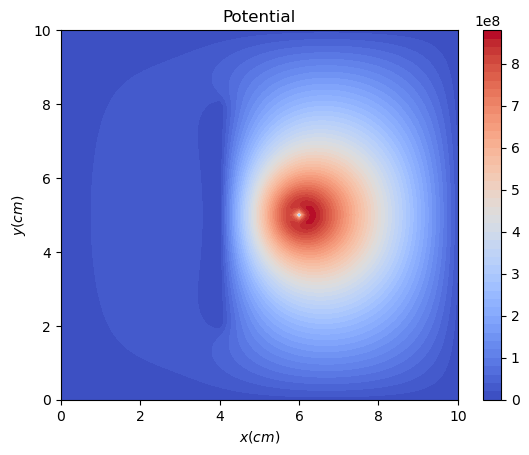

In [6]:
plt.contourf(xx, yy, V, 50,cmap = 'coolwarm')
plt.colorbar()
plt.xlabel("$x(cm)$")
plt.ylabel("$y(cm)$")
plt.title("Potential")
plt.show()

We can clearly see that the potential is radial and does indeed show a proportionality to $\frac{1}{r^2}$ (the contour is very bright and dense as you move closer to the point charge). we can aslo see the effect that the electrode has on the potential. It is sort of blocking and forcing it to wrap around it. 

We now want to calculate the electric field. This can be done using the formular 
$$-\nabla \phi(x,y) = E(x,y)$$

In python we simply find the gradient of the potential using $\textit{np.gradient}$.

In [7]:
# Calculate the electric field
Ex, Ey = np.gradient(-V, x, y)

# Calculate the magnitude and angle of the electric field
magnitude = np.sqrt(Ex**2 + Ey**2)
angle = np.arctan2(Ey, Ex)

for i, point in enumerate(points):
    x_index, y_index = indices[i]
    electric_field_magnitude = magnitude[x_index, y_index]
    electric_field_angle = np.degrees(angle[x_index, y_index])
    print(f"Electric Field at {point}: Magnitude = {electric_field_magnitude:.2f}, Angle = {electric_field_angle:.2f} degrees")

Electric Field at (5, 5): Magnitude = 6223247.29, Angle = -90.00 degrees
Electric Field at (9, 5): Magnitude = 2655828.79, Angle = 90.00 degrees
Electric Field at (9, 9): Magnitude = 1455917.35, Angle = 24.55 degrees
Electric Field at (4.05, 2): Magnitude = 2955723.83, Angle = -16.43 degrees
Electric Field at (3.95, 2): Magnitude = 2065816.26, Angle = 32.07 degrees
Electric Field at (4, 2): Magnitude = 2955723.83, Angle = -16.43 degrees
Electric Field at (4, 8): Magnitude = 2955723.83, Angle = -163.57 degrees


The above just computes the electric field at the points we highlighted above. This results into a vector field with x and y components which we use to compute the magnitude of the electric field at the specified grid point and the angle between the x-axis and that point using the formular $\theta = \arctan(E_y/E_x)$.

We then plot the resulting vector field of the electric field.

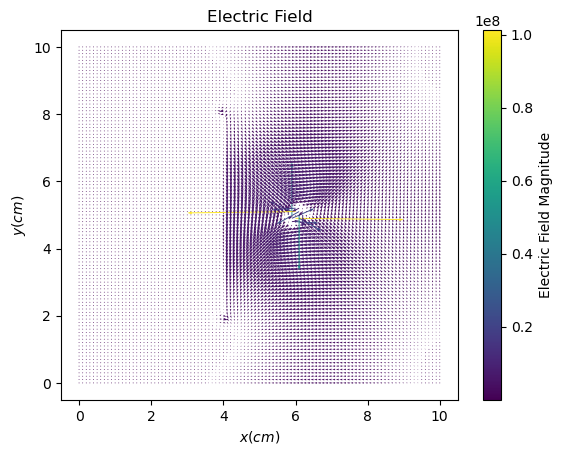

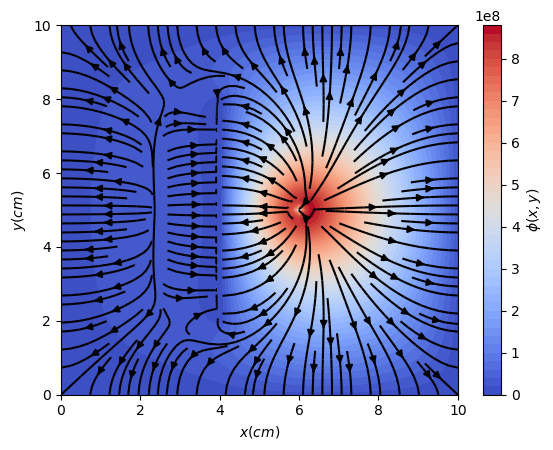

In [9]:
# Visualize the vector field
plt.quiver(xx, yy, Ex, Ey, magnitude, cmap='viridis')
plt.xlabel('$x(cm)$')
plt.ylabel('$y(cm)$')
plt.title('Electric Field')
plt.colorbar(label='Electric Field Magnitude')
plt.show()

def plotE(psi, n):
    v, u = np.gradient(psi) #grad of E field
    
    x = np.linspace(0, 10, n) # x-axis
    fig, axarr = plt.subplots()

    im1 = axarr.contourf(x, x, psi, 50,cmap = 'coolwarm') #basically makes x,y grid
    axarr.streamplot(x, x, -u, -v, density=1.4, color="black") #plots the E field vectors
    fig.colorbar(im1, orientation='vertical', ax=axarr,label=(r"$\phi(x,y)$")) #adds colorbar
    axarr.set_xlabel("$x(cm)$")
    axarr.set_ylabel("$y(cm)$")

plotE(V,N)
plt.show()

The first plot is the vector field of the electric field plotted with magnitudes to properly visualize it. We can, however see that it doesn't tell us much. So we also make a plot of the electric field lines which shows us exactly how it looks like in the box.

For the last part, we want ot determine the charge distribution on the electrode. So make use of the expression:
$$(E_2 - E_1)  \hat{n} = \frac{\lambda}{\epsilon_0}$$
where $\lambda$ is the charge density.

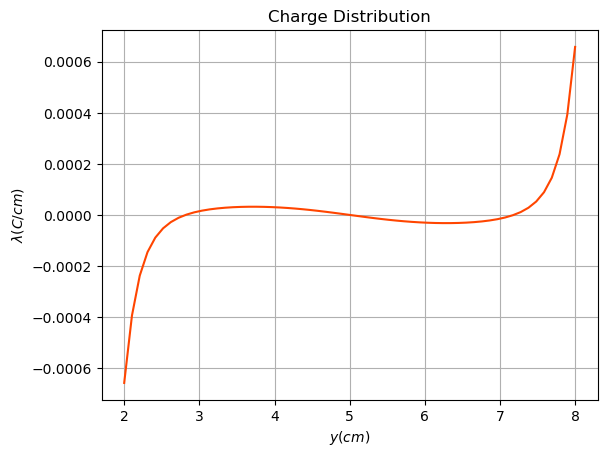

The total charge is = -1.9109063290057016e-18 C




In [10]:
lam = []
E_perp_above = Ex[21:80,40] #electric field to the right of the line
E_perp_below = Ex[21:80,38] #electric field to the left of the line


for i in range(len(E_perp_above)):
    a = (E_perp_above[i] - E_perp_below[i])*epsilon0 #applying boundary condition
    lam.append(a)
    
    

area = ele_thickness*6    
y = np.linspace(2,8,59) #the corresponding y points where the line charge density was calculated

# plt.figure(10)
plt.plot(y,np.array(lam),color = 'orangered')
plt.grid()
plt.xlabel(r'$y(cm)$')
plt.ylabel(r'$\lambda(C/cm)$')
plt.title('Charge Distribution')
plt.show()


dy = y[1] - y[0] #spacing of y
charge = simps(lam,y,dy,axis = -1) #using simpsons rule to calculate integral of line charge density 
print('The total charge is =', charge, 'C')
print('\n')

We simply intergrate over the line to find the charge density which we then plot as a function of of the distance along the line (y). This plot shows us how the charges on the elelctrode are arranged to give us a zero potential. The can clearly see that this is an odd function and thus most of charge are arranged such that The total charge on the electrode is zero as we can see that the change is very small (at the order $\times 10^{-18}$).